In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import pyarrow as pa
import gzip
import io
from tqdm import tqdm

import seaborn as sns
from scipy.spatial.distance import pdist, squareform

In [2]:
# higashi_schema = pa.schema(
#     [
#         ("cell_name", pa.string()),
#         ("cell_id", pa.int32()),
#         ("chrom1", pa.string()),
#         ("pos1", pa.int64()),
#         ("chrom2", pa.string()),
#         ("pos2", pa.int64()),
#         ("count", pa.int32()),
#     ]
# )


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# !chmod +x /content/drive/Shareddrives/MLCB_project_dataset/unzip_tar_v3.sh
# !/content/drive/Shareddrives/MLCB_project_dataset/unzip_tar_v3.sh

In [16]:

# dataset_path = '/content/drive/Shareddrives/MLCB_project_dataset/'
dataset_path = '/n/netscratch/zhuang_lab/Lab/Peter/higashi_dnamerfish'
libraries_path = '/n/home09/pren/libraries'
fish_path = os.path.join(dataset_path, 'multiplexed_fish')
hic_path = os.path.join(dataset_path, 'schic_snm3cseq')
hic_ecker_2023_path = os.path.join(hic_path, 'data')

# fish_datasets = ['liu_zhuang_2023_p1', 'liu_zhuang_2023_p2', 'murphy_boetigger_2024', 'takei_cai_2021_science', 'takei_cai_2024']
# hic_datasets = ['liu_ecker_2021', 'liu_ecker_2023']

fish_datasets = ['4DNESMTNNB3N', '4DNESPE924IP']
fish_path1 = os.path.join(fish_path, fish_datasets[0])
fish_path2 = os.path.join(fish_path, fish_datasets[1])


In [11]:
# liu_zhuang_2023_p1 accession numbers (cell_info, dna_info)
liu_zhuang_2023_p1_accs = [('4DNFIA7FUW8Y', '4DNFIMCISOJB'), ('4DNFI3R71II5', '4DNFIM9T6MT5'), ('4DNFINMD8PA4', '4DNFIC62S1V9'), ('4DNFICX8IVEK', '4DNFI78AIUP8')]

# liu_zhuang_2023_p2 accession numbers (cell_info, dna_info)4DNFIM453D3J
liu_zhuang_2023_p2_accs = [('4DNFIGGW8X11', '4DNFIY7ULW4E'), ('4DNFIQ8VF1OM', '4DNFIDJJZFYF'), ('4DNFIZQML8A6', '4DNFIM453D3J'), ('4DNFIKRWUGOQ', '4DNFIN99DPHD')]


There are 8 csv files containing xyz position data, each with (TODO: how many cells per csv file)?. If 1 min/cell to convert to distance DataFrame, how long will it take to get to 10000 cells?

In [13]:
cell_df = pd.read_csv(os.path.join(fish_path1, '4DNFIA7FUW8Y.csv'), skiprows=22)
cell_df

,##columns=(Cell_ID,FOV_ID,cell_volume_from_merlin,cell_center_x_global,cell_center_y_global,RNA_experiment_ID,Sample_ID,cluster_subclass,cluster_class,neuron_identity,...,Unc13c,Unc5b,Unc5d,Ust,Vipr2,Vtn,Vwc2,Wipf3,Wnt7b,Zfp804b)
0,103489270985795086009915676188840872439,0,403.121799,-5984.643199,3962.926100,20220304,C57BL/6_M_1_MOp_1,Astro,Astro,Non-Neuronal,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,113811790893231448949429397438012891173,0,1345.443053,-6046.845801,3943.378100,20220304,C57BL/6_M_1_MOp_1,other,other,other,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,119547840309256440899855144626134392385,0,866.273544,-6009.207800,3915.406099,20220304,C57BL/6_M_1_MOp_1,other,other,other,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,120849314423504941338008541020153695260,0,1186.181156,-6114.885802,3938.572100,20220304,C57BL/6_M_1_MOp_1,other,other,other,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,125550627244524118102850004242680097855,0,281.811702,-6190.485804,3985.876101,20220304,C57BL/6_M_1_MOp_1,Peri,Peri,Non-Neuronal,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17851,89740340849279220555487673174291177981,167,746.108561,3028.620050,-2372.662093,20220304,C57BL/6_M_1_MOp_1,L5/6 NP,Gluta,Neuronal,...,5.0,0.0,0.0,1.0,1.0,0.0,0.0,8.0,0.0,1.0
17852,90550019712359509388050476283813007625,167,931.565237,3093.798051,-2484.658096,20220304,C57BL/6_M_1_MOp_1,L6 CT,Gluta,Neuronal,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,30.0,0.0,0.0
17853,91790428117198932838975210302149417238,167,146.709916,3073.926051,-2429.902094,20220304,C57BL/6_M_1_MOp_1,Astro,Astro,Non-Neuronal,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17854,95847719459140129344505526245510134602,167,264.662706,3019.332049,-2441.458095,20220304,C57BL/6_M_1_MOp_1,L6 CT,Gluta,Neuronal,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,1.0


In [14]:
dna_df = pd.read_csv(os.path.join(fish_path1, '4DNFIMCISOJB.csv'), skiprows=22)
dna_df

,##columns=(Spot_ID,Trace_ID,X,Y,Z,Chrom,Chrom_Start,Chrom_End,Chrom_order,Cell_ID,FOV_ID,CellID_byFOV,RNA_experiment_ID,DNA_experiment_ID,Sample_ID)
0,0,0_12_17_1,27.243158,159.901718,6.553304,chr17,73751388,73759983,52,259202492748634617304623818845147108919,0,12,20220304,20220316,C57BL/6_M_1_MOp_1
1,8,0_12_11_1,24.689795,162.147971,8.598524,chr11,103751349,103759972,88,259202492748634617304623818845147108919,0,12,20220304,20220316,C57BL/6_M_1_MOp_1
2,13,0_12_6_1,26.512251,159.940303,5.219720,chr6,6248757,6259999,4,259202492748634617304623818845147108919,0,12,20220304,20220316,C57BL/6_M_1_MOp_1
3,18,0_12_18_1,24.463309,157.307263,3.973699,chr18,6245525,6256029,1,259202492748634617304623818845147108919,0,12,20220304,20220316,C57BL/6_M_1_MOp_1
4,25,0_12_4_1,26.385614,158.051149,6.099972,chr4,56251843,56259955,43,259202492748634617304623818845147108919,0,12,20220304,20220316,C57BL/6_M_1_MOp_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8258324,49906463,98_99_1_2,105.995147,118.947701,5.123158,chr1,20920666,20929358,9,87771478147559922311523693539230586180,98,99,20220304,20220316,C57BL/6_M_1_MOp_1
8258325,49906479,98_99_19_2,103.131581,117.087217,9.817099,chr19,58830419,58839344,55,87771478147559922311523693539230586180,98,99,20220304,20220316,C57BL/6_M_1_MOp_1
8258326,49906517,98_99_2_1,104.765538,117.879538,4.755127,chr2,25440503,25448101,19,87771478147559922311523693539230586180,98,99,20220304,20220316,C57BL/6_M_1_MOp_1
8258327,49906527,98_99_13_1,102.239847,115.740916,5.205479,chr13,111402714,111414250,85,87771478147559922311523693539230586180,98,99,20220304,20220316,C57BL/6_M_1_MOp_1


In [15]:
def split_name(name):
  chrom, chrom_start_end = name.split(':')
  chrom_start, chrom_end = chrom_start_end.split('-')
  return pd.Series([chrom, chrom_start, chrom_end], index=['Chrom', 'Chrom_Start', 'Chrom_End'])

In [17]:
codebook_df = pd.read_csv(os.path.join(libraries_path, 'ctp11_wholemouse/CTP11-1000_codebook_probe.csv'))
codebook_df

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_824,NDB_712,NDB_818,NDB_940,NDB_872,NDB_934,NDB_926,NDB_910,chr,chr_order
0,1:3742742-3759944,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
1,1:6245958-6258969,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.0
2,1:8740008-8759916,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.0
3,1:11247744-11257616,4,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,3.0
4,1:13741888-13757922,5,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,X:161247067-161259813,1057,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,X,52.0
984,X:163750534-163758706,1058,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,X,53.0
985,X:166247682-166259932,1059,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,X,54.0
986,X:168746045-168757590,1060,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,55.0


In [18]:
codebook_df[['Chrom', 'Chrom_Start', 'Chrom_End']] = codebook_df['name'].apply(split_name)
codebook_ref_df = codebook_df[['Chrom', 'Chrom_Start', 'Chrom_End', 'chr_order']]
codebook_ref_df = codebook_ref_df.rename(columns={'chr_order': 'Chrom_order'})
codebook_ref_df['Chrom'] = codebook_ref_df['Chrom'].map(lambda x: f'chr{x}')
codebook_ref_df = codebook_ref_df.astype({'Chrom_Start': 'int64', 'Chrom_End': 'int64', 'Chrom_order': 'int64'})
codebook_ref_df


,Chrom,Chrom_Start,Chrom_End,Chrom_order
0,chr1,3742742,3759944,0
1,chr1,6245958,6258969,1
2,chr1,8740008,8759916,2
3,chr1,11247744,11257616,3
4,chr1,13741888,13757922,4
...,...,...,...,...
983,chrX,161247067,161259813,52
984,chrX,163750534,163758706,53
985,chrX,166247682,166259932,54
986,chrX,168746045,168757590,55


In [19]:
codebook_ref_df.dtypes

Chrom          object
Chrom_Start     int64
Chrom_End       int64
Chrom_order     int64
dtype: object

In [20]:
cell_1_test = dna_df.loc[dna_df['Cell_ID'] == "259202492748634617304623818845147108919"]
cell_1_test = cell_1_test.rename(columns={cell_1_test.columns[0]: 'Spot_ID'})

cell_1_mean = cell_1_test.groupby(["Chrom", "Chrom_Start", "Chrom_End", "Cell_ID", "Chrom_order"]).agg({
    "X": "mean",
    "Y": "mean",
    "Z": "mean",
    # Add other columns to aggregate as needed
}).reset_index()
cell_1_mean

,Chrom,Chrom_Start,Chrom_End,Cell_ID,Chrom_order,X,Y,Z
0,chr1,3742742,3759944,259202492748634617304623818845147108919,0,26.668485,158.111222,4.147276
1,chr1,9799472,9811359,259202492748634617304623818845147108919,4,26.547060,159.360091,4.753624
2,chr1,11247744,11257616,259202492748634617304623818845147108919,5,27.348482,158.644037,5.500038
3,chr1,20920666,20929358,259202492748634617304623818845147108919,9,26.111182,159.211332,5.381981
4,chr1,21249750,21259997,259202492748634617304623818845147108919,10,26.075276,159.080377,4.415525
...,...,...,...,...,...,...,...,...
797,chr9,106935532,106964965,259202492748634617304623818845147108919,86,24.364855,162.762386,5.246824
798,chr9,108749775,108759943,259202492748634617304623818845147108919,88,24.304186,163.012916,5.710913
799,chr9,109532055,109558895,259202492748634617304623818845147108919,89,25.142241,162.547393,6.534312
800,chr9,111249941,111259901,259202492748634617304623818845147108919,92,24.178891,163.021673,5.636320


In [21]:
cell_1_test.dtypes

Spot_ID                int64
Trace_ID              object
X                    float64
Y                    float64
Z                    float64
Chrom                 object
Chrom_Start            int64
Chrom_End              int64
Chrom_order            int64
Cell_ID               object
FOV_ID                 int64
CellID_byFOV           int64
RNA_experiment_ID      int64
DNA_experiment_ID      int64
Sample_ID)            object
dtype: object

In [22]:
def add_missing_entries(df_main, df_ref, compare_cols, fill_values):
    """
    Add missing entries to df_main based on df_ref, comparing specified columns.

    Parameters:
    - df_main: Main DataFrame to be updated.
    - df_ref: Reference DataFrame containing desired combinations.
    - compare_cols: List of column names to compare.
    - fill_values: Dictionary of column names and values to fill for missing entries.

    Returns:
    - Updated DataFrame with missing entries added.
    """
    # Merge df_ref with df_main to find missing entries
    merged = df_ref.merge(df_main[compare_cols], on=compare_cols, how='left', indicator=True)
    missing_entries = merged[merged['_merge'] == 'left_only'][compare_cols]

    # Add fill values to missing entries
    for col, value in fill_values.items():
        missing_entries[col] = value

    # Append missing entries to df_main
    df_updated = pd.concat([df_main, missing_entries], ignore_index=True, sort=False)
    return df_updated

fill_cols = {'Cell_ID': 259202492748634617304623818845147108919, 'X': np.nan, 'Y': np.nan, 'Z': np.nan}
cell_1_test_nans = add_missing_entries(cell_1_test, codebook_ref_df, ['Chrom', 'Chrom_Start', 'Chrom_End', 'Chrom_order'], fill_cols)
cell_1_mean_nans = cell_1_test_nans.groupby(["Chrom", "Chrom_Start", "Chrom_End", "Cell_ID", "Chrom_order"]).agg({
    "X": "mean",
    "Y": "mean",
    "Z": "mean",
    # Add other columns to aggregate as needed
}).reset_index()
cell_1_mean_nans

,Chrom,Chrom_Start,Chrom_End,Cell_ID,Chrom_order,X,Y,Z
0,chr1,3742742,3759944,259202492748634617304623818845147108919,0,26.668485,158.111222,4.147276
1,chr1,6245958,6258969,259202492748634617304623818845147108919,1,NaN,NaN,NaN
2,chr1,8740008,8759916,259202492748634617304623818845147108919,2,NaN,NaN,NaN
3,chr1,9799472,9811359,259202492748634617304623818845147108919,4,26.547060,159.360091,4.753624
4,chr1,11247744,11257616,259202492748634617304623818845147108919,3,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1773,chrX,161247067,161259813,259202492748634617304623818845147108919,52,NaN,NaN,NaN
1774,chrX,163750534,163758706,259202492748634617304623818845147108919,53,NaN,NaN,NaN
1775,chrX,166247682,166259932,259202492748634617304623818845147108919,54,NaN,NaN,NaN
1776,chrX,168746045,168757590,259202492748634617304623818845147108919,55,NaN,NaN,NaN


In [23]:
# Initialize an empty list to store distances
distances = []

# Convert the relevant columns to a numpy array
points = cell_1_mean_nans[["X", "Y", "Z"]].values

# Compute pairwise distances using scipy's pdist
pairwise_distances = pdist(points, metric='euclidean')

In [24]:
cell_1_mean_nans =cell_1_mean_nans.sort_values(by=["Chrom", "Chrom_order"]).reset_index(drop=True)
cell_1_mean_nans

,Chrom,Chrom_Start,Chrom_End,Cell_ID,Chrom_order,X,Y,Z
0,chr1,3742742,3759944,259202492748634617304623818845147108919,0,26.668485,158.111222,4.147276
1,chr1,6245958,6258969,259202492748634617304623818845147108919,1,NaN,NaN,NaN
2,chr1,8740008,8759916,259202492748634617304623818845147108919,2,NaN,NaN,NaN
3,chr1,11247744,11257616,259202492748634617304623818845147108919,3,NaN,NaN,NaN
4,chr1,9799472,9811359,259202492748634617304623818845147108919,4,26.547060,159.360091,4.753624
...,...,...,...,...,...,...,...,...
1773,chrX,161247067,161259813,259202492748634617304623818845147108919,52,NaN,NaN,NaN
1774,chrX,163750534,163758706,259202492748634617304623818845147108919,53,NaN,NaN,NaN
1775,chrX,166247682,166259932,259202492748634617304623818845147108919,54,NaN,NaN,NaN
1776,chrX,168746045,168757590,259202492748634617304623818845147108919,55,NaN,NaN,NaN


In [25]:
distance_matrix = pd.DataFrame(squareform(pairwise_distances))
# distance_matrix.index = cell_1_mean["##columns=(Spot_ID"].to_list()
# distance_matrix.columns = cell_1_mean["##columns=(Spot_ID"].to_list()
distance_matrix

,0,1,2,3,4,5,6,7,8,9,...,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777
0,0.000000,NaN,NaN,1.393584,NaN,1.605070,NaN,NaN,NaN,1.745086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.393584,NaN,NaN,0.000000,NaN,1.308489,NaN,NaN,NaN,0.779071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


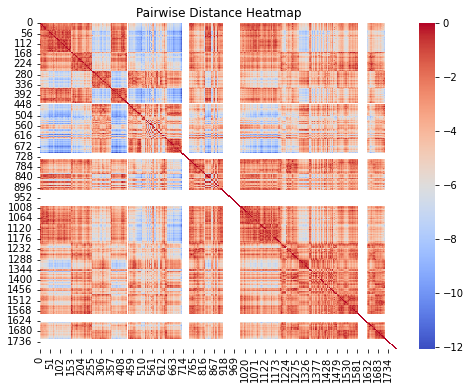

In [26]:
plt.figure(figsize=(8, 6))
sns.heatmap(-1*distance_matrix, cmap="coolwarm", fmt=".2f")
plt.title("Pairwise Distance Heatmap")
plt.show()

In [28]:
cell_1_mean_nans["med_pos"] = ((cell_1_mean_nans["Chrom_Start"] + cell_1_mean_nans["Chrom_End"])/2).astype(int)
n = len(points)
pairs = []
for i in range(len(distance_matrix.index)):
    for j in range(len(distance_matrix.columns)):
      if i < j: # keep the lower triangle
        chr1 = cell_1_mean_nans.loc[i, "Chrom"]
        chr2 = cell_1_mean_nans.loc[j, "Chrom"]
        pos1 = cell_1_mean_nans.loc[i, "med_pos"]
        pos2 = cell_1_mean_nans.loc[j, "med_pos"]
        #cellid = cell_1_mean.loc[i, "Cell_ID"]
        cellid = 0
        pairs.append((cellid, chr1, pos1, chr2, pos2, distance_matrix.iloc[i, j]))

distance_df = pd.DataFrame(pairs, columns=["cell_id", "chrom1", "pos1", "chrom2", "pos2", "Distance"])
# Sort the DataFrame by Distance
# sorted_distance_df = distance_df.sort_values(by="loci1").reset_index(drop=True)
distance_df

,cell_id,chrom1,pos1,chrom2,pos2,Distance
0,0,chr1,3751343,chr1,6252463,NaN
1,0,chr1,3751343,chr1,8749962,NaN
2,0,chr1,3751343,chr1,11252680,1.393584
3,0,chr1,3751343,chr1,9805415,NaN
4,0,chr1,3751343,chr1,13749905,1.605070
...,...,...,...,...,...,...
1579748,0,chrX,163754620,chrX,168751817,NaN
1579749,0,chrX,163754620,chrY,1252883,NaN
1579750,0,chrX,166253807,chrX,168751817,NaN
1579751,0,chrX,166253807,chrY,1252883,NaN


In [29]:
# example_path = os.path.join(hic_ecker_2023_path, '11F_DGV_3C_3-4-B8-F19.3C.contact', '11F_DGV_3C_3-4-B8-F19.3C.contact.tsv.gz')

# contact_df = pd.read_csv(
#                 example_path,
#                 sep="\t",
#                 header=None,
#                 names=["ph1a", "chrom1", "pos1", "ph1b", "ph2a", "chrom2", "pos2", "ph2b"],
#                 compression="gzip",
#                 low_memory=False,
#                 )
# contact_df


In [30]:
# # Load scHi-C df

# def process_schic_tsvs(data_dir):
#   # dataframes = []
#   filenames = []
#   for idx, cur_dir in enumerate(os.listdir(data_dir)):
#     print('cur_dir: ', cur_dir)
#     cur_file = os.path.join(data_dir, cur_dir, f'{cur_dir}.tsv.gz')
#     filenames.append(cur_file)
#     cur_df = pd.read_csv(
#                 cur_file,
#                 sep="\t",
#                 header=None,
#                 names=["ph1a", "chrom1", "pos1", "ph1b", "ph2a", "chrom2", "pos2", "ph2b"],
#                 compression="gzip",
#                 low_memory=False,
#                 )
#     # cur_df["cell_name"] = cur_dir
#     cur_df["cell_id"] = idx
#     cur_df["count"] = 1
#     # cur_df = cur_df[["cell_name", "cell_id", "chrom1", "pos1", "chrom2", "pos2", "count"]]
#     cur_df = cur_df[["chrom1", "pos1", "chrom2", "pos2", "count"]]
#     cur_df.to_csv(os.path.splitext(cur_file)[0] + '_proc.tsv', sep='\t')

#     # dataframes.append(cur_df)
#   # return pd.concat(dataframes, ignore_index=True)
#   return filenames
# schic_filenames = process_schic_tsvs(hic_ecker_2023_path)
# schic_filenames


# Higashi on DNA-MERFISH

In [31]:
test1_dir = '/n/netscratch/zhuang_lab/Lab/Peter/higashi_dnamerfish/test1'

In [ ]:
def createDistMat(df, codebook_ref_df):
  merged_df_100 = []
  unique_cells = df.Cell_ID.unique()[:100]
  for c in tqdm(range(len(unique_cells)), desc="Processing Cells"):
    cellid = unique_cells[c]
    cell = dna_df.loc[dna_df['Cell_ID'] == cellid]
    cell = cell.rename(columns={cell.columns[0]: 'Spot_ID'})
    fill_cols = {'Cell_ID': cellid, 'X': np.nan, 'Y': np.nan, 'Z': np.nan}
    cell_1_test_nans = add_missing_entries(cell, codebook_ref_df, ['Chrom', 'Chrom_Start', 'Chrom_End', 'Chrom_order'], fill_cols)
    cell_mean = cell_1_test_nans.groupby(["Chrom", "Chrom_Start", "Chrom_End", "Cell_ID", "Chrom_order"]).agg({
        "X": "mean",
        "Y": "mean",
        "Z": "mean",
        # Add other columns to aggregate as needed
    }).reset_index()
    # Initialize an empty list to store distances
    distances = []

    # Convert the relevant columns to a numpy array
    points = cell_mean[["X", "Y", "Z"]].values

    # Compute pairwise distances using scipy's pdist
    pairwise_distances = pdist(points, metric='euclidean')
    distance_matrix = pd.DataFrame(squareform(pairwise_distances))
    cell_mean["med_pos"] = ((cell_mean["Chrom_Start"] + cell_mean["Chrom_End"])/2).astype(int)
    n = len(points)
    pairs = []
    for i in range(len(distance_matrix.index)):
        for j in range(len(distance_matrix.columns)):
          if i < j: # keep the lower triangle
            chr1 = cell_mean.loc[i, "Chrom"]
            chr2 = cell_mean.loc[j, "Chrom"]
            pos1 = cell_mean.loc[i, "med_pos"]
            pos2 = cell_mean.loc[j, "med_pos"]
            #cellid = cell_2_mean.loc[i, "Cell_ID"]
            cell_id = c
            pairs.append((cell_id, chr1, pos1, chr2, pos2, distance_matrix.iloc[i, j]))

    distance_df = pd.DataFrame(pairs, columns=["cell_id", "chrom1", "pos1", "chrom2", "pos2", "distance"])
    # distance_df = pd.DataFrame(pairs, columns=["cell_id", "chrom1", "pos1", "chrom2", "pos2", "count"])
    # distance_df["count"] = (distance_df['count'] - distance_df['count'].min()) / (distance_df['count'].max() - distance_df['count'].min())
    if len(merged_df_100) == 0:
      merged_df_100 = distance_df
    else:
      merged_df_100 = pd.concat([merged_df_100, distance_df], ignore_index=True)
  return merged_df_100

merged_df_100 = createDistMat(dna_df, codebook_ref_df)
merged_df_100.to_csv(os.path.join(test1_dir, 'merfish_dist_test_data.txt'), sep='\t', index=False)
merged_df_100


Processing Cells:  44%|████▍     | 44/100 [38:49<28:02, 30.04s/it]  

In [ ]:
def convert_dist_to_contact_df(dist_df, thresh):
  def threshold_contact(distance):
    if distance <= thresh:
      return 1
    else:
      return 0
  dist_df['count'] = dist_df['distance'].apply(threshold_contact)
  print('dist_df: ', dist_df)
  contact_df = dist_df.drop('distance', axis=1)
  return contact_df

In [ ]:
merged_contact_df_100 = convert_dist_to_contact_df(merged_df_100, 0.75)
merged_contact_df_100

In [ ]:
merged_contact_df_100.to_csv(os.path.join(test1_dir, 'merfish_thresh750nm_test_data.txt'), sep='\t', index=False)

In [21]:
# merged_contact_df_100 = pd.read_csv(os.path.join(test1_dir, 'merfish_thresh750nm_test_data.txt'), sep='\t')



In [22]:
np.sum(merged_contact_df_100['count'])

627729

In [ ]:
!git clone https://github.com/ma-compbio/Higashi/
!cd Higashi
!python setup.py install

Cloning into 'Higashi'...
remote: Enumerating objects: 1406, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 1406 (delta 67), reused 124 (delta 57), pack-reused 1268 (from 1)
Receiving objects: 100% (1406/1406), 190.30 MiB | 27.92 MiB/s, done.
Resolving deltas: 100% (848/848), done.
Updating files: 100% (101/101), done.
python3: can't open file '/content/setup.py': [Errno 2] No such file or directory


In [ ]:
# from higashi.Higashi_wrapper import *
import pickle
import json


In [ ]:
label_info = {'cell_id': np.arange(100)
              }

pickle.dump(label_info, open("./merfish_thresh1_test_label_info.pickle", "wb"))

In [ ]:
config = '/content/merfish_thresh1_test_config.JSON'
config_info = {
    "data_dir": "/content",
    "label_path": "/content/merfish_thresh1_test_label_info.pickle",
    "structured": True,
    "input_format": 'higashi_v1',
    "temp_dir": "/content/",
    "genome_reference_path": "/content/chromInfo.txt",
    "cytoband_path": "/content/cytoBand.txt",
    "chrom_list": ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr17', 'chr18', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr9',
       'chr16', 'chr19', 'chr2', 'chr8', "chrX"],
    "resolution": 500000,
    "resolution_cell": 500000,
    "resolution_fh": [500000],
    "embedding_name": "test",
    "minimum_distance": 500000,
    "maximum_distance": -1,
    "local_transfer_range": 0,
    "loss_mode": "zinb",
    "dimensions": 64,
    "impute_list":['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr17', 'chr18', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr9',
       'chr16', 'chr19', 'chr2', 'chr8', "chrX"],
    "neighbor_num": 5,
    "cpu_num": 10,
    "gpu_num": 8,
    "embedding_epoch":5,
    "correct_be_impute": True,
}
import json
with open(config,"w") as f:
    json.dump(config_info, f, indent = 6)

In [ ]:
# Initialize the Higashi instance
higashi_model = Higashi(config)

# Data processing (only needs to be run for once)

higashi_model.generate_chrom_start_end()
higashi_model.extract_table()
higashi_model.create_matrix()

In [ ]:
higashi_model.prep_model()

In [ ]:
higashi_model.train_for_embeddings()

In [ ]:
# Visualize embedding results
cell_embeddings = higashi_model.fetch_cell_embeddings()
print(cell_embeddings.shape)

from umap import UMAP

vec = UMAP(n_components=2, n_neighbors=2, random_state=0).fit_transform(cell_embeddings)
cell_type = higashi_model.label_info['cell type']
batch = higashi_model.label_info['batch']
fig = plt.figure(figsize=(14, 5))
ax = plt.subplot(1, 2, 1)
sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=cell_type, ax=ax, s=5, alpha=0.8, linewidth=0, hue_order=['GM12878','IMR90','HFF', 'HAP1', 'H1Esc'])
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
ax = plt.subplot(1, 2, 2)
sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=batch, ax=ax, s=5, alpha=0.8, linewidth=0)
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
plt.tight_layout()
plt.show()

In [ ]:
higashi_model.train_for_imputation_nbr_0()
higashi_model.impute_no_nbr()

In [ ]:
higashi_model.train_for_imputation_with_nbr()
higashi_model.impute_with_nbr()

In [ ]:
count = 0
fig = plt.figure(figsize=(6, 2*5))
for id_ in np.random.randint(0, 620, 5):
    ori, nbr0, nbr5 = higashi_model.fetch_map("chr3", id_)
    count += 1
    ax = plt.subplot(5, 3, count * 3 - 2)
    ax.imshow(ori.toarray(), cmap='Reds', vmin=0.0, vmax=np.quantile(ori.data, 0.6))
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    if count == 1:
        ax.set_title("raw")

    ax = plt.subplot(5, 3, count * 3 - 1)
    ax.imshow(nbr0.toarray(), cmap='Reds', vmin=0.0, vmax=np.quantile(nbr0.data, 0.95))
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    if count == 1:
        ax.set_title("higashi, k=0")

    ax = plt.subplot(5, 3, count * 3)
    ax.imshow(nbr5.toarray(), cmap='Reds', vmin=0.0, vmax=np.quantile(nbr5.data, 0.95))
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    if count == 1:
        ax.set_title("higashi, k=5")

plt.tight_layout()